In [8]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from faker import Faker 
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

#import project configuration
import sys 
sys.path.append('..')
import config

# set random seeds for reproductibility 
np.random.seed(config.RANDOM_SEED)
fake = Faker()
Faker.seed(config.RANDOM_SEED)

print("Libraries imported succesfully")
print(f"Target sample size: {config.N_PERSONNEL} personnel")
print(f"Data range: {config.START_DATE} to {config.END_DATE}")

Libraries imported succesfully
Target sample size: 1000 personnel
Data range: 2019-01-01 to 2024-12-31


# Generate Personnel Profiles 

In [9]:
def generate_base_personnel(n=config.N_PERSONNEL):
    """
    Generate base personnel profiles with demographics and identifiers.
    
    Parameters:
    -----------
    n : int
        Number of personnel records to generate
    
    Returns:
    --------
    pd.DataFrame with base personnel information
    """
    
    data = []
    
    for i in range(n):
        #Generate service branch(weighted distribution)
        branch = np.random.choice(
            list(config.BRANCH_DISTRIBUTION.keys()),
            p=list(config.BRANCH_DISTRIBUTION.values())
        
        )
        
        # Generate rank (weighted distribution)
        rank = np.random.choice(
            list(config.RANK_DISTRIBUTION.keys()),
            p=list(config.RANK_DISTRIBUTION.values())
        
        )
        
         # Years of service correlated with rank
        if rank == "Junior":
            years_service = np.random.randint(0, 8)
            age = np.random.randint(18, 30)
        elif rank == "NCO":
            years_service = np.random.randint(5, 18)
            age = np.random.randint(25, 42)
        else:  # Officer
            years_service = np.random.randint(8, 30)
            age = np.random.randint(28, 55)
        
        # Contract end date (current date + remaining contract)
        contract_months_remaining = np.random.randint(1, 48)  # 1-48 months
        contract_end = datetime.strptime(config.END_DATE, "%Y-%m-%d") + timedelta(days=contract_months_remaining*30)
        
        record = {
            'personnel_id': f"MIL{str(i+1).zfill(5)}",
            'name': fake.name(),
            'age': age,
            'gender': np.random.choice(config.GENDER_OPTIONS),
            'service_branch': branch,
            'rank': rank,
            'MOS': np.random.choice(config.MOS_LIST),
            'years_of_service': years_service,
            'contract_end_date': contract_end.strftime("%Y-%m-%d"),
            'marital_status': np.random.choice(config.MARITAL_STATUS_OPTIONS, p=[0.35, 0.50, 0.12, 0.03]),
            'dependents': np.random.randint(0, 6),
            'education_level': np.random.choice(
                config.EDUCATION_LEVELS,
                p=[0.30, 0.20, 0.35, 0.12, 0.03]  # Most have high school or bachelor's
            )
        }
        
        data.append(record)
    
    df = pd.DataFrame(data)
    
    # Calculate months until contract end
    df['contract_end_date'] = pd.to_datetime(df['contract_end_date'])
    current_date = pd.to_datetime(config.END_DATE)
    df['months_until_contract_end'] = ((df['contract_end_date'] - current_date).dt.days / 30).round(0).astype(int)
    
    return df

# Generate base personnel
personnel_df = generate_base_personnel()

print(f"Generated {len(personnel_df)} personnel records")
print(f"\nSample records:")
personnel_df.head()
    

Generated 1000 personnel records

Sample records:


,personnel_id,name,age,gender,service_branch,rank,MOS,years_of_service,contract_end_date,marital_status,dependents,education_level,months_until_contract_end
0,MIL00001,Allison Hill,35,Male,Army,Officer,Military Police,18,2026-09-22,Single,2,Associate,21
1,MIL00002,Noah Rhodes,23,Female,Army,Junior,Cyber Operations,2,2025-03-01,Divorced,1,High School,2
2,MIL00003,Angie Henderson,29,Male,Army,Junior,Special Forces,5,2027-01-20,Married,1,High School,25
3,MIL00004,Daniel Wagner,20,Male,Air Force,Junior,Aviation,5,2028-08-12,Married,2,Master,44
4,MIL00005,Cristian Santos,21,Female,Navy,Junior,Administration,1,2027-01-20,Married,0,High School,25


# Add Training & Skills Features 

In [10]:
def add_training_features(df):
    """
    Add training history and skills features.
    Correlations: Higher rank -> more training, better scores
    """
    
    # Training hours correlated with years of service
    df['total_training_hours'] = (df['years_of_service'] * 80 + 
                                   np.random.normal(0, 200, len(df))).clip(0, 2000).round(0).astype(int)
    
    # Specialized courses (more for officers)
    df['specialized_courses_completed'] = np.where(
        df['rank'] == 'Officer',
        np.random.randint(5, 16, len(df)),
        np.where(
            df['rank'] == 'NCO',
            np.random.randint(2, 10, len(df)),
            np.random.randint(0, 6, len(df))
        )
    )
    
    # Training scores (normally distributed around 80)
    df['training_score_average'] = np.random.normal(80, 10, len(df)).clip(60, 100).round(1)
    
    # Certifications held
    df['certifications_held'] = (df['specialized_courses_completed'] * 0.5 + 
                                  np.random.randint(0, 4, len(df))).clip(0, 8).astype(int)
    
    # Days since last training (recent training = better readiness)
    df['days_since_last_training'] = np.random.randint(1, 730, len(df))  # 0-2 years
    
    # Skills current (True if trained in last 12 months)
    df['skills_current'] = df['days_since_last_training'] <= 365
    
    # Training budget spent (correlated with courses)
    df['training_budget_spent'] = (df['specialized_courses_completed'] * 2000 + 
                                    np.random.randint(-5000, 5000, len(df))).clip(0, 50000)
    
    return df

personnel_df = add_training_features(personnel_df)
print("Training features added")
personnel_df[['personnel_id', 'rank', 'total_training_hours', 'specialized_courses_completed', 
              'training_score_average', 'skills_current']].head()

Training features added


,personnel_id,rank,total_training_hours,specialized_courses_completed,training_score_average,skills_current
0,MIL00001,Officer,1226,8,91.6,False
1,MIL00002,Junior,420,3,79.8,True
2,MIL00003,Junior,548,0,78.8,False
3,MIL00004,Junior,656,0,70.6,True
4,MIL00005,Junior,0,4,74.2,True


# Add Health & Fitness Features 


In [11]:
def add_health_features(df):
    """
    Add health and fitness features.
    Correlations: Better health -> better performance, lower attrition risk
    """
    
    # Health index (composite metric, 50-100)
    # Slightly decreases with age
    age_penalty = (df['age'] - 18) * 0.3
    df['health_index'] = (90 - age_penalty + np.random.normal(0, 10, len(df))).clip(50, 100).round(1)
    
    # Physical fitness score (correlated with health index)
    df['physical_fitness_score'] = (df['health_index'] * 0.7 + 
                                     np.random.normal(20, 15, len(df))).clip(0, 100).round(1)
    
    # Medical restrictions (10% of personnel)
    df['medical_restrictions'] = np.random.choice([True, False], len(df), p=[0.10, 0.90])
    
    # Days on medical leave (more if have restrictions or poor health)
    base_leave = np.random.exponential(10, len(df))
    df['days_on_medical_leave'] = np.where(
        df['medical_restrictions'] | (df['health_index'] < 70),
        base_leave * 3,
        base_leave
    ).clip(0, 180).round(0).astype(int)
    
    # Mental health status
    df['mental_health_status'] = np.random.choice(
        config.MENTAL_HEALTH_STATUS,
        len(df),
        p=[0.30, 0.45, 0.20, 0.05]  # Most are good/excellent
    )
    
    # Wellness program participation
    df['wellness_program_participation'] = np.random.choice([True, False], len(df), p=[0.40, 0.60])
    
    return df

personnel_df = add_health_features(personnel_df)
print("Health & fitness features added")
personnel_df[['personnel_id', 'age', 'health_index', 'physical_fitness_score', 
              'medical_restrictions', 'mental_health_status']].head()

Health & fitness features added


,personnel_id,age,health_index,physical_fitness_score,medical_restrictions,mental_health_status
0,MIL00001,35,84.6,71.3,False,Good
1,MIL00002,23,93.1,64.2,False,Excellent
2,MIL00003,29,82.5,76.8,False,Excellent
3,MIL00004,20,86.7,100.0,False,Good
4,MIL00005,21,81.8,72.0,False,Good


# Add Leave & Attendance Features

In [12]:
def add_leave_features(df):
    """
    Add leave and attendance features.
    High leave usage can indicate dissatisfaction or personal issues.
    """
    
    # Annual leave taken (most use 10-20 days)
    df['annual_leave_taken'] = np.random.normal(15, 7, len(df)).clip(0, 30).round(0).astype(int)
    
    # Emergency leave incidents (rare, 0-2 for most)
    df['emergency_leave_incidents'] = np.random.choice([0, 1, 2, 3, 4, 5], len(df), p=[0.50, 0.25, 0.15, 0.07, 0.02, 0.01])
    
    # Unauthorized absences (very rare, disciplinary issue)
    df['unauthorized_absences'] = np.random.choice([0, 1, 2, 3], len(df), p=[0.85, 0.10, 0.04, 0.01])
    
    # Leave balance (remaining days)
    df['leave_balance'] = (30 - df['annual_leave_taken']).clip(0, 30)
    
    # Leave to service ratio (normalized leave usage)
    df['leave_to_service_ratio'] = (df['annual_leave_taken'] / 
                                     df['years_of_service'].replace(0, 1)).round(2)
    
    return df

personnel_df = add_leave_features(personnel_df)
print("Leave & attendance features added")
personnel_df[['personnel_id', 'annual_leave_taken', 'emergency_leave_incidents', 
              'unauthorized_absences', 'leave_balance']].head()

Leave & attendance features added


,personnel_id,annual_leave_taken,emergency_leave_incidents,unauthorized_absences,leave_balance
0,MIL00001,25,0,1,5
1,MIL00002,12,0,0,18
2,MIL00003,23,1,0,7
3,MIL00004,9,0,0,21
4,MIL00005,0,2,0,30


# Add Mission & Deployment Features

In [13]:
def add_deployment_features(df):
    """
    Add mission and deployment history features.
    More deployments can boost readiness but also increase attrition risk (fatigue).
    """
    
    # Total deployments (correlated with years of service)
    deployment_rate = 0.3  # ~1 deployment every 3 years
    df['total_deployments'] = (df['years_of_service'] * deployment_rate + 
                                np.random.randint(0, 3, len(df))).clip(0, 8).astype(int)
    
    # Months deployed in last 3 years
    df['months_deployed_last_3yrs'] = np.where(
        df['total_deployments'] > 0,
        np.random.randint(3, 36, len(df)),
        0
    )
    
    # Deployment type (if deployed)
    df['deployment_type'] = np.where(
        df['total_deployments'] > 0,
        np.random.choice(config.DEPLOYMENT_TYPES, len(df), p=[0.40, 0.35, 0.25]),
        'None'
    )
    
    # Months since last deployment
    df['months_since_last_deployment'] = np.where(
        df['total_deployments'] > 0,
        np.random.randint(1, 36, len(df)),
        999  # Never deployed
    )
    
    # Mission performance rating (1-5, higher is better)
    df['mission_performance_rating'] = np.where(
        df['total_deployments'] > 0,
        np.random.choice([1, 2, 3, 4, 5], len(df), p=[0.05, 0.10, 0.30, 0.40, 0.15]),
        3  # Default for non-deployed
    )
    
    # Combat exposure level
    df['combat_exposure_level'] = np.where(
        df['deployment_type'] == 'Combat',
        np.random.choice(['Low', 'Moderate', 'High'], len(df), p=[0.40, 0.40, 0.20]),
        np.where(
            df['deployment_type'] == 'International',
            np.random.choice(['None', 'Low'], len(df), p=[0.70, 0.30]),
            'None'
        )
    )
    
    return df

personnel_df = add_deployment_features(personnel_df)
print("Mission & deployment features added")
personnel_df[['personnel_id', 'total_deployments', 'months_deployed_last_3yrs', 
              'deployment_type', 'mission_performance_rating']].head()

Mission & deployment features added


,personnel_id,total_deployments,months_deployed_last_3yrs,deployment_type,mission_performance_rating
0,MIL00001,6,23,Combat,4
1,MIL00002,0,0,None,3
2,MIL00003,1,31,International,4
3,MIL00004,2,29,International,5
4,MIL00005,2,31,Combat,3


# Add Performance & Dicipline Features 

In [15]:
def add_performance_features(df):
    """
    Add performance review and discipline features.
    Performance is correlated with health, training, and deployment experience.
    """
    
    # Base performance score (influenced by multiple factors)
    base_performance = 75
    health_bonus = (df['health_index'] - 75) * 0.2
    training_bonus = (df['training_score_average'] - 80) * 0.1
    deployment_bonus = np.where(df['total_deployments'] > 0, 5, 0)
    
    df['performance_review_score'] = (
        base_performance + health_bonus + training_bonus + deployment_bonus + 
        np.random.normal(0, 8, len(df))
    ).clip(60, 100).round(1)
    
    # Commendations (awards, correlated with performance)
    df['commendations'] = np.where(
        df['performance_review_score'] > 85,
        np.random.randint(2, 11, len(df)),
        np.random.randint(0, 5, len(df))
    )
    
    # Disciplinary actions (rare, negatively correlated with performance)
    discipline_prob = np.where(
        df['performance_review_score'] < 70,
        0.30,  # 30% chance if low performer
        0.05   # 5% chance otherwise
    )
    df['disciplinary_actions'] = np.where(
        np.random.random(len(df)) < discipline_prob,
        np.random.randint(1, 4, len(df)),
        0
    )
    
    # Leadership potential (higher for officers and high performers)
    df['leadership_potential_score'] = (
        df['performance_review_score'] * 0.6 + 
        np.where(df['rank'] == 'Officer', 20, 0) +
        np.random.normal(0, 10, len(df))
    ).clip(0, 100).round(1)
    
    # Promotion eligible (based on time in service and performance)
    df['promotion_eligible'] = (
        (df['years_of_service'] >= 4) & 
        (df['performance_review_score'] >= 75) &
        (df['disciplinary_actions'] == 0)
    )
    
    # Peer rating score (similar to performance but with noise)
    df['peer_rating_score'] = (df['performance_review_score'] + 
                                np.random.normal(0, 10, len(df))).clip(0, 100).round(1)
    
    return df

personnel_df = add_performance_features(personnel_df)
print("Performance & discipline features added")
personnel_df[['personnel_id', 'performance_review_score', 'commendations', 
              'disciplinary_actions', 'leadership_potential_score', 'promotion_eligible']].head()

Performance & discipline features added


,personnel_id,performance_review_score,commendations,disciplinary_actions,leadership_potential_score,promotion_eligible
0,MIL00001,79.3,2,0,57.0,True
1,MIL00002,81.0,1,0,44.5,False
2,MIL00003,82.0,1,0,60.5,True
3,MIL00004,86.7,9,0,31.7,True
4,MIL00005,78.5,4,0,68.1,False


# Add Personal Factors 

In [16]:
def add_personal_factors(df):
    """
    Add personal factors that influence attrition decisions.
    """
    
    # Civilian job offers (more likely for high performers and those near contract end)
    job_offer_prob = (
        (df['performance_review_score'] > 80).astype(int) * 0.3 +
        (df['months_until_contract_end'] < 12).astype(int) * 0.2
    )
    df['civilian_job_offers'] = np.where(
        np.random.random(len(df)) < job_offer_prob,
        np.random.randint(1, 4, len(df)),
        0
    )
    
    # Financial stress (more likely with dependents, less likely with higher rank)
    stress_score = (
        df['dependents'] * 10 - 
        np.where(df['rank'] == 'Officer', 20, 0) +
        np.random.randint(-10, 10, len(df))
    )
    df['financial_stress_indicator'] = pd.cut(
        stress_score,
        bins=[-np.inf, 10, 25, np.inf],
        labels=['Low', 'Medium', 'High']
    )
    
    # Family support score (normally distributed)
    df['family_support_score'] = np.random.normal(70, 20, len(df)).clip(0, 100).round(1)
    
    # Relocation willingness (affects deployment readiness)
    df['relocation_willingness'] = np.random.choice(
        config.RELOCATION_WILLINGNESS,
        len(df),
        p=[0.20, 0.50, 0.30]
    )
    
    return df

personnel_df = add_personal_factors(personnel_df)
print("Personal factors added")
personnel_df[['personnel_id', 'civilian_job_offers', 'financial_stress_indicator', 
              'family_support_score', 'relocation_willingness']].head()

Personal factors added


,personnel_id,civilian_job_offers,financial_stress_indicator,family_support_score,relocation_willingness
0,MIL00001,0,Low,95.6,Low
1,MIL00002,0,Low,24.6,High
2,MIL00003,0,Low,61.7,Medium
3,MIL00004,1,Medium,69.3,Medium
4,MIL00005,0,Low,38.7,Low


##  Calculate Target Variables

### Target 1: Attrition Risk (Classification)
### Target 2: Readiness Score (Regression)

In [18]:
def calculate_attrition_risk(df):
    """
    Calculate attrition risk based on multiple factors.
    Uses logistic function to determine probability of leaving.
    """
    
    # Build attrition risk score (higher = more likely to leave)
    risk_score = 0
    
    # Contract pressure (strongest factor)
    risk_score += np.where(df['months_until_contract_end'] < 6, 40,
                  np.where(df['months_until_contract_end'] < 12, 30,
                  np.where(df['months_until_contract_end'] < 24, 15, 0)))
    
    # Civilian job offers
    risk_score += df['civilian_job_offers'] * 10
    
    # Health issues
    risk_score += np.where(df['health_index'] < 70, 15, 0)
    
    # Poor performance
    risk_score += np.where(df['performance_review_score'] < 70, 10, 0)
    
    # Financial stress
    risk_score += np.where(df['financial_stress_indicator'] == 'High', 10,
                  np.where(df['financial_stress_indicator'] == 'Medium', 5, 0))
    
    # Disciplinary issues
    risk_score += df['disciplinary_actions'] * 5
    
    # Deployment fatigue
    risk_score += np.where(df['months_deployed_last_3yrs'] > 24, 10, 0)
    
    # Family factors
    risk_score += np.where(df['family_support_score'] < 50, 8, 0)
    
    # Add some random variation
    risk_score += np.random.normal(0, 10, len(df))
    
    # Convert to categories based on thresholds
    df['attrition_risk_score'] = risk_score.clip(0, 100)
    df['attrition_risk'] = pd.cut(
        df['attrition_risk_score'],
        bins=[0, 40, 65, 100],
        labels=['LOW_RISK', 'MEDIUM_RISK', 'HIGH_RISK']
    )
    
    return df

def calculate_readiness_score(df):
    """
    Calculate individual readiness score (0-100).
    Based on training, health, deployment experience, performance, and skills.
    """
    
    # Training currency component (30%)
    training_component = (
        df['training_score_average'] * 0.5 +
        np.where(df['skills_current'], 25, 0) +
        np.where(df['days_since_last_training'] < 180, 25, 0)
    ) * 0.30
    
    # Health & fitness component (25%)
    health_component = (
        df['health_index'] * 0.6 +
        df['physical_fitness_score'] * 0.4
    ) * 0.25
    
    # Deployment experience component (20%)
    # Recent deployment boosts readiness, but decays over time
    deployment_recency_bonus = np.where(
        df['months_since_last_deployment'] < 6, 20,
        np.where(df['months_since_last_deployment'] < 12, 15,
        np.where(df['months_since_last_deployment'] < 24, 10, 5))
    )
    deployment_component = (
        np.where(df['total_deployments'] > 0, 70, 40) +
        deployment_recency_bonus
    ) * 0.20
    
    # Performance component (15%)
    performance_component = df['performance_review_score'] * 0.15
    
    # Skill specialization component (10%)
    skill_component = (
        df['certifications_held'] * 10 +
        df['specialized_courses_completed'] * 2
    ).clip(0, 100) * 0.10
    
    # Sum all components
    readiness = (
        training_component +
        health_component +
        deployment_component +
        performance_component +
        skill_component
    )
    
    # Add noise and clip to 0-100
    df['readiness_score'] = (
        readiness + np.random.normal(0, 5, len(df))
    ).clip(0, 100).round(1)
    
    # Categorical readiness
    df['readiness_category'] = pd.cut(
        df['readiness_score'],
        bins=[0, 70, 80, 100],
        labels=['Not Ready', 'Limited', 'Ready']
    )
    
    return df

# Calculate both targets
personnel_df = calculate_attrition_risk(personnel_df)
personnel_df = calculate_readiness_score(personnel_df)

print("Target variables calculated")
print("\nAttrition Risk Distribution:")
print(personnel_df['attrition_risk'].value_counts(normalize=True))
print("\nReadiness Score Statistics:")
print(personnel_df['readiness_score'].describe())
print("\nReadiness Category Distribution:")
print(personnel_df['readiness_category'].value_counts(normalize=True))

Target variables calculated

Attrition Risk Distribution:
attrition_risk
LOW_RISK       0.697905
MEDIUM_RISK    0.232635
HIGH_RISK      0.069460
Name: proportion, dtype: float64

Readiness Score Statistics:
count    1000.000000
mean       71.153700
std         9.110339
min        42.400000
25%        64.900000
50%        71.300000
75%        77.525000
max        99.300000
Name: readiness_score, dtype: float64

Readiness Category Distribution:
readiness_category
Not Ready    0.453
Limited      0.378
Ready        0.169
Name: proportion, dtype: float64


# Add Missing Data 

In [19]:
def introduce_missing_data(df, missing_pct=config.MISSING_DATA_PCT):
    """
    Introduce realistic missing data patterns.
    Some features are more likely to have missing values (e.g., health, leave records).
    """
    
    # Features that can have missing values
    missingness_config = {
        'days_on_medical_leave': missing_pct,
        'mental_health_status': missing_pct * 0.5,
        'emergency_leave_incidents': missing_pct,
        'family_support_score': missing_pct * 1.5,
        'peer_rating_score': missing_pct * 2,
        'wellness_program_participation': missing_pct,
        'civilian_job_offers': missing_pct * 0.8
    }
    
    for feature, miss_rate in missingness_config.items():
        if feature in df.columns:
            mask = np.random.random(len(df)) < miss_rate
            df.loc[mask, feature] = np.nan
    
    return df

personnel_df = introduce_missing_data(personnel_df)

print("Missing data introduced")
print("\nMissing Data Summary:")
missing_summary = personnel_df.isnull().sum()[personnel_df.isnull().sum() > 0].sort_values(ascending=False)
missing_pct = (missing_summary / len(personnel_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_pct
})
print(missing_df)

Missing data introduced

Missing Data Summary:
                                Missing Count  Missing %
peer_rating_score                         140       14.0
family_support_score                      111       11.1
attrition_risk                             93        9.3
days_on_medical_leave                      75        7.5
wellness_program_participation             70        7.0
emergency_leave_incidents                  70        7.0
civilian_job_offers                        47        4.7
mental_health_status                       35        3.5


# Data Validation 

In [21]:
def validate_data(df):
    """
    Validate generated data meets specifications.
    """
    
    print("-" * 60)
    print("DATA VALIDATION REPORT")
    print("-" * 60)
    
    # Check 1: Sample size
    print(f"\n Sample Size: {len(df)} records (Target: {config.N_PERSONNEL})")
    
    # Check 2: Number of features
    print(f" Number of Features: {len(df.columns)} columns")
    
    # Check 3: Target distributions
    print("\n Attrition Risk Distribution:")
    attrition_dist = df['attrition_risk'].value_counts(normalize=True).sort_index()
    for risk_level, pct in attrition_dist.items():
        target_pct = config.ATTRITION_RISK_DISTRIBUTION.get(risk_level, 0)
        status = "True" if abs(pct - target_pct) < 0.05 else "False"
        print(f"  {status} {risk_level}: {pct:.1%} (Target: {target_pct:.1%})")
    
    # Check 4: Readiness score statistics
    print("\n Readiness Score Statistics:")
    print(f"  Mean: {df['readiness_score'].mean():.1f} (Target: ~{config.READINESS_MEAN})")
    print(f"  Std: {df['readiness_score'].std():.1f} (Target: ~{config.READINESS_STD})")
    print(f"  Min: {df['readiness_score'].min():.1f}")
    print(f"  Max: {df['readiness_score'].max():.1f}")
    
    # Check 5: Branch distribution
    print("\n Service Branch Distribution:")
    branch_dist = df['service_branch'].value_counts(normalize=True)
    for branch, pct in branch_dist.items():
        target_pct = config.BRANCH_DISTRIBUTION.get(branch, 0)
        status = "TRUE" if abs(pct - target_pct) < 0.05 else "False"
        print(f"  {status} {branch}: {pct:.1%} (Target: {target_pct:.1%})")
    
    # Check 6: Rank distribution
    print("\n Rank Distribution:")
    rank_dist = df['rank'].value_counts(normalize=True)
    for rank, pct in rank_dist.items():
        target_pct = config.RANK_DISTRIBUTION.get(rank, 0)
        status = "True" if abs(pct - target_pct) < 0.05 else "False"
        print(f"  {status} {rank}: {pct:.1%} (Target: {target_pct:.1%})")
    
    # Check 7: Missing data
    total_missing_pct = df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100
    print(f"\n Overall Missing Data: {total_missing_pct:.2f}% (Target: ~{config.MISSING_DATA_PCT*100:.1f}%)")
    
    # Check 8: Key correlations
    print("\n Key Correlations:")
    health_performance_corr = df[['health_index', 'performance_review_score']].corr().iloc[0, 1]
    print(f"  Health - Performance: {health_performance_corr:.3f} (Expected: > 0.3)")
    
    training_readiness_corr = df[['training_score_average', 'readiness_score']].corr().iloc[0, 1]
    print(f"  Training - Readiness: {training_readiness_corr:.3f} (Expected: > 0.3)")
    
    # Check 9: Data types
    print("\n Data Types Summary:")
    print(f"  Numeric: {df.select_dtypes(include=[np.number]).shape[1]} features")
    print(f"  Categorical: {df.select_dtypes(include=['object', 'category']).shape[1]} features")
    print(f"  Boolean: {df.select_dtypes(include=['bool']).shape[1]} features")
    
    print("\n" + "-" * 60)
    print("DATA VALIDATION COMPLETE")
    print("-" * 60)
    
validate_data(personnel_df)

------------------------------------------------------------
DATA VALIDATION REPORT
------------------------------------------------------------

 Sample Size: 1000 records (Target: 1000)
 Number of Features: 51 columns

 Attrition Risk Distribution:
  False LOW_RISK: 69.8% (Target: 45.0%)
  False MEDIUM_RISK: 23.3% (Target: 30.0%)
  False HIGH_RISK: 6.9% (Target: 25.0%)

 Readiness Score Statistics:
  Mean: 71.2 (Target: ~75.0)
  Std: 9.1 (Target: ~12.0)
  Min: 42.4
  Max: 99.3

 Service Branch Distribution:
  TRUE Army: 61.0% (Target: 60.0%)
  TRUE Navy: 20.3% (Target: 20.0%)
  TRUE Air Force: 18.7% (Target: 20.0%)

 Rank Distribution:
  True Junior: 50.3% (Target: 50.0%)
  True NCO: 35.8% (Target: 35.0%)
  True Officer: 13.9% (Target: 15.0%)

 Overall Missing Data: 1.26% (Target: ~7.0%)

 Key Correlations:
  Health - Performance: 0.223 (Expected: > 0.3)
  Training - Readiness: 0.145 (Expected: > 0.3)

 Data Types Summary:
  Numeric: 31 features
  Categorical: 16 features
  Boolean: 

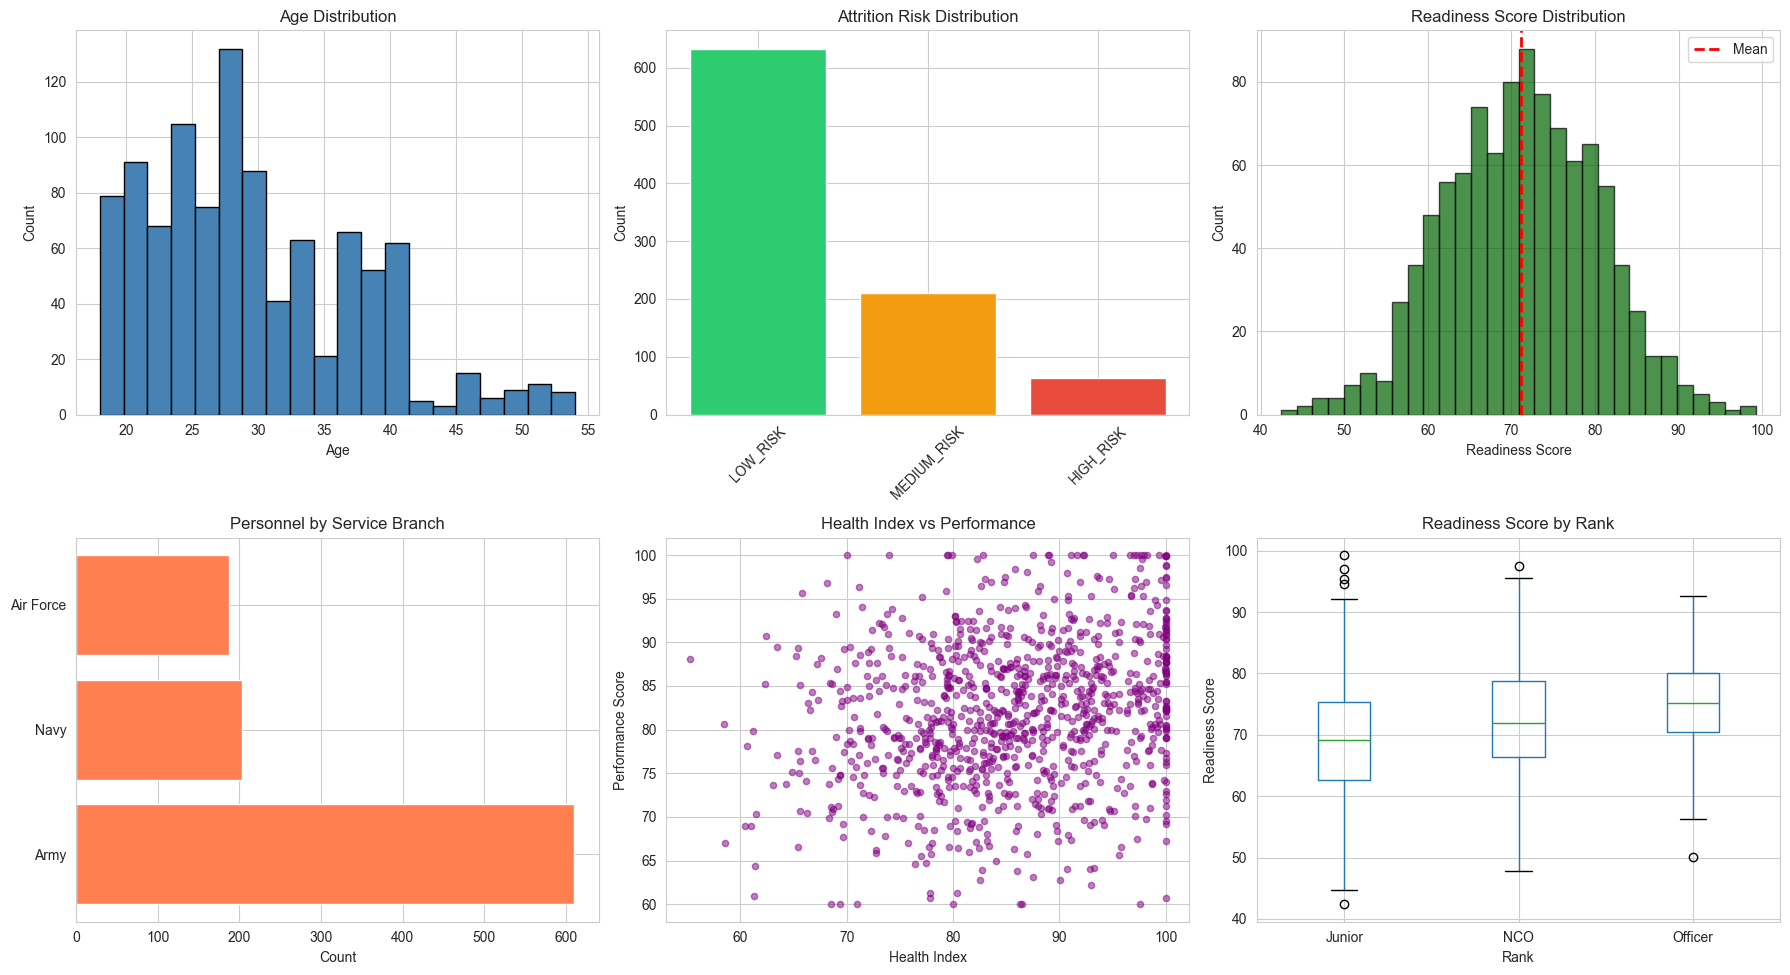

Visualization saved to reports/figures/data_generation_overview.png


In [22]:
# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Synthetic Data - Quick Overview', fontsize=16, fontweight='bold')

# 1. Age distribution
axes[0, 0].hist(personnel_df['age'], bins=20, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Count')

# 2. Attrition risk distribution
attrition_counts = personnel_df['attrition_risk'].value_counts()
colors = [config.ATTRITION_COLORS[risk] for risk in attrition_counts.index]
axes[0, 1].bar(range(len(attrition_counts)), attrition_counts.values, color=colors)
axes[0, 1].set_xticks(range(len(attrition_counts)))
axes[0, 1].set_xticklabels(attrition_counts.index, rotation=45)
axes[0, 1].set_title('Attrition Risk Distribution')
axes[0, 1].set_ylabel('Count')

# 3. Readiness score distribution
axes[0, 2].hist(personnel_df['readiness_score'], bins=30, color='darkgreen', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(personnel_df['readiness_score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 2].set_title('Readiness Score Distribution')
axes[0, 2].set_xlabel('Readiness Score')
axes[0, 2].set_ylabel('Count')
axes[0, 2].legend()

# 4. Service branch distribution
branch_counts = personnel_df['service_branch'].value_counts()
axes[1, 0].barh(range(len(branch_counts)), branch_counts.values, color='coral')
axes[1, 0].set_yticks(range(len(branch_counts)))
axes[1, 0].set_yticklabels(branch_counts.index)
axes[1, 0].set_title('Personnel by Service Branch')
axes[1, 0].set_xlabel('Count')

# 5. Health vs Performance scatter
axes[1, 1].scatter(personnel_df['health_index'], personnel_df['performance_review_score'], 
                   alpha=0.5, c='purple', s=20)
axes[1, 1].set_title('Health Index vs Performance')
axes[1, 1].set_xlabel('Health Index')
axes[1, 1].set_ylabel('Performance Score')

# 6. Readiness by rank boxplot
rank_order = ['Junior', 'NCO', 'Officer']
personnel_df['rank'] = pd.Categorical(personnel_df['rank'], categories=rank_order, ordered=True)
personnel_df.boxplot(column='readiness_score', by='rank', ax=axes[1, 2])
axes[1, 2].set_title('Readiness Score by Rank')
axes[1, 2].set_xlabel('Rank')
axes[1, 2].set_ylabel('Readiness Score')
plt.suptitle('')  # Remove default title

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'data_generation_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved to reports/figures/data_generation_overview.png")

In [23]:
# Save the raw dataset
output_path = config.RAW_DATA_DIR / config.PERSONNEL_DATA_FILE
personnel_df.to_csv(output_path, index=False)
print(f" Dataset saved to: {output_path}")
print(f"   Shape: {personnel_df.shape}")
print(f"   Size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")

 Dataset saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\data\raw\military_personnel.csv
   Shape: (1000, 51)
   Size: 0.26 MB


In [24]:
# Create comprehensive data dictionary
data_dictionary = [
    # Demographics
    ('personnel_id', 'Unique identifier for each personnel', 'Categorical', 'MIL00001-MIL01000'),
    ('name', 'Anonymous name', 'Text', 'Fake names'),
    ('age', 'Age in years', 'Numeric', '18-55'),
    ('gender', 'Gender', 'Categorical', 'Male, Female'),
    ('service_branch', 'Military branch', 'Categorical', 'Army, Navy, Air Force'),
    ('rank', 'Military rank level', 'Categorical', 'Junior, NCO, Officer'),
    ('MOS', 'Military Occupational Specialty', 'Categorical', '15 specialties'),
    ('years_of_service', 'Total years in service', 'Numeric', '0-30'),
    ('contract_end_date', 'Contract expiration date', 'Date', 'YYYY-MM-DD'),
    ('months_until_contract_end', 'Months until contract expires', 'Numeric', 'Calculated'),
    
    # Training & Skills
    ('total_training_hours', 'Cumulative training hours', 'Numeric', '0-2000'),
    ('specialized_courses_completed', 'Number of specialized courses', 'Numeric', '0-15'),
    ('training_score_average', 'Average training assessment score', 'Numeric', '60-100'),
    ('certifications_held', 'Number of active certifications', 'Numeric', '0-8'),
    ('days_since_last_training', 'Days since last training session', 'Numeric', '0-730'),
    ('skills_current', 'Skills are current (trained in last 12 months)', 'Boolean', 'True/False'),
    ('training_budget_spent', 'Total training budget spent ($)', 'Numeric', '0-50000'),
    
    # Health & Fitness
    ('health_index', 'Composite health metric', 'Numeric', '50-100'),
    ('physical_fitness_score', 'PT test score', 'Numeric', '0-100'),
    ('medical_restrictions', 'Has medical restrictions', 'Boolean', 'True/False'),
    ('days_on_medical_leave', 'Medical leave days (per year)', 'Numeric', '0-180'),
    ('mental_health_status', 'Mental health assessment', 'Categorical', 'Excellent/Good/Fair/Concern'),
    ('wellness_program_participation', 'Participates in wellness programs', 'Boolean', 'True/False'),
    
    # Leave & Attendance
    ('annual_leave_taken', 'Annual leave days used', 'Numeric', '0-30'),
    ('emergency_leave_incidents', 'Emergency leave instances', 'Numeric', '0-5'),
    ('unauthorized_absences', 'Unauthorized absence incidents', 'Numeric', '0-3'),
    ('leave_balance', 'Remaining leave days', 'Numeric', '0-30'),
    ('leave_to_service_ratio', 'Leave usage normalized by service years', 'Numeric', 'Calculated'),
    
    # Mission & Deployment
    ('total_deployments', 'Total career deployments', 'Numeric', '0-8'),
    ('months_deployed_last_3yrs', 'Months deployed in last 3 years', 'Numeric', '0-36'),
    ('deployment_type', 'Most recent deployment type', 'Categorical', 'Domestic/International/Combat/None'),
    ('months_since_last_deployment', 'Months since last deployment', 'Numeric', '0-999'),
    ('mission_performance_rating', 'Mission performance rating', 'Numeric', '1-5'),
    ('combat_exposure_level', 'Combat exposure level', 'Categorical', 'None/Low/Moderate/High'),
    
    # Performance & Discipline
    ('performance_review_score', 'Annual performance review score', 'Numeric', '60-100'),
    ('commendations', 'Number of commendations/awards', 'Numeric', '0-10'),
    ('disciplinary_actions', 'Number of disciplinary actions', 'Numeric', '0-5'),
    ('leadership_potential_score', 'Leadership assessment score', 'Numeric', '0-100'),
    ('promotion_eligible', 'Eligible for promotion', 'Boolean', 'True/False'),
    ('peer_rating_score', 'Peer evaluation score', 'Numeric', '0-100'),
    
    # Personal Factors
    ('marital_status', 'Marital status', 'Categorical', 'Single/Married/Divorced/Widowed'),
    ('dependents', 'Number of dependents', 'Numeric', '0-5'),
    ('education_level', 'Highest education level', 'Categorical', 'High School/Associate/Bachelor/Master/Doctorate'),
    ('civilian_job_offers', 'Number of civilian job offers', 'Numeric', '0-3'),
    ('financial_stress_indicator', 'Financial stress level', 'Categorical', 'Low/Medium/High'),
    ('family_support_score', 'Family support assessment', 'Numeric', '0-100'),
    ('relocation_willingness', 'Willingness to relocate', 'Categorical', 'Low/Medium/High'),
    
    # Target Variables
    ('attrition_risk_score', 'Continuous attrition risk score', 'Numeric', '0-100'),
    ('attrition_risk', 'Attrition risk category (TARGET 1)', 'Categorical', 'LOW_RISK/MEDIUM_RISK/HIGH_RISK'),
    ('readiness_score', 'Deployment readiness score (TARGET 2)', 'Numeric', '0-100'),
    ('readiness_category', 'Readiness category', 'Categorical', 'Not Ready/Limited/Ready')
]

dict_df = pd.DataFrame(data_dictionary, columns=['Feature', 'Description', 'Type', 'Range/Values'])
dict_path = config.DATA_DIR / config.DATA_DICTIONARY_FILE
dict_df.to_csv(dict_path, index=False)

print(f"Data dictionary saved to: {dict_path}")
print(f"\nData Dictionary Preview:")
dict_df.head(10)

Data dictionary saved to: C:\Users\hp\Desktop\gaf\Ghana-Armed-Forces-Personnel-Deployment-and-Attrition-Risk-Modeling\data\data_dictionary.csv

Data Dictionary Preview:


,Feature,Description,Type,Range/Values
0,personnel_id,Unique identifier for each personnel,Categorical,MIL00001-MIL01000
1,name,Anonymous name,Text,Fake names
2,age,Age in years,Numeric,18-55
3,gender,Gender,Categorical,"Male, Female"
4,service_branch,Military branch,Categorical,"Army, Navy, Air Force"
5,rank,Military rank level,Categorical,"Junior, NCO, Officer"
6,MOS,Military Occupational Specialty,Categorical,15 specialties
7,years_of_service,Total years in service,Numeric,0-30
8,contract_end_date,Contract expiration date,Date,YYYY-MM-DD
9,months_until_contract_end,Months until contract expires,Numeric,Calculated
